In [ ]:
import os
import yaml
from pathlib import Path


import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import lightning.pytorch as pl

import model.IndexLSTM as index_net
import model.ViTLSTM as vit_net

from utils import statics_from_config
from utils_data import generate_clim_pred, load_data
from plot_utils import *
import utils_evaluation as eval



In [2]:
import matplotlib as mpl
mpl.get_configdir()

'/mnt/beegfs/home/bommer1/.config/matplotlib'

In [3]:
plt.style.use('seaborn')


/tmp/ipykernel_66863/2955780531.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Model and Prediction Function

# Results

In [ ]:
# Set hyperparameters.
arch_type = 'Index_LSTM' # 'LSTM' # 'ViT'
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf']  #762a83
regimes = ['SB', 'NAO-', 'AR', 'NAO+']

exd = os.path.dirname(os.path.abspath(__file__))
cfd = exd.parent.absolute()

root_path = str(cfd.parent.absolute())+'/Data'
data_path = f"{root_path}/"
res_path = str(cfd.parent.absolute()) + f'/Data/Results/'
if arch_type == 'ViT':

        cfile = '_1980_olr'
        config = yaml.load(open(f'{cfd}/config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)


        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        stat_dir =  config['net_root'] + f'Statistics/{arch}'
        result_path = f'{res_path}/Statistics/{arch}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)


        mod_name = 'ViT_LSTM'
        architecture = vit_net.ViT_LSTM
        
elif arch_type == 'LSTM':
        cfile = '_1980_olr'
        config = yaml.load(open(f'{cfd}/config/config{cfile}.yaml'), Loader=yaml.FullLoader)


        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        stat_dir =  config['net_root'] + f'Statistics/{arch_type}/'
        result_path = f'{res_path}Statistics/{arch_type}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)

        mod_name = 'ViT_LSTM'
        architecture = vit_net.ViT_LSTM

else:
        config = yaml.load(open(f'{cfd}/config/config_1980_index.yaml'), Loader=yaml.FullLoader)

        config_base = yaml.load(open(f'{cfd}/config/config_1980_olr.yaml'), Loader=yaml.FullLoader)

        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)


        stat_dir =  config['net_root'] + f'Statistics/{arch_type}/'
        result_path = f'{res_path}Statistics/{arch_type}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)
        mod_name = 'Index_LSTM'
        architecture = index_net.IndexLSTM


test_loader, data_set, cls_wt, test_set, infos = load_data(config)

var_comb = config['var_comb']

data_info, _ = statics_from_config(config)

seasons =  {'train':{config['data']['dataset_name2']:list(range(config['data']['fine']['train_start'], config['data']['fine']['train_end']))},
'val':{config['data']['dataset_name2']:list(range(config['data']['fine']['val_start'], config['data']['fine']['val_end']))},
'test':{config['data']['dataset_name2']:list(range(config['data']['fine']['test_start'], config['data']['fine']['test_end']))}}

~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc


In [7]:
# Load collected data.
exp_dir =  f"{stat_dir}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/"
pths = [xs for xs in Path(exp_dir).iterdir() if xs.is_dir()]

if temp_scaling:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}_temp_scale.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model_temp_scale.npz')
else:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model.npz')
    
persistance = data_collect['persistance'] 
sst = data_collect['sst'] 
u10 = data_collect['u10'] 
dates = data_collect['dates'] 
daytimes = data_collect['daytimes']
loop_probabilities = data_collect['loop_probabilities']
loop_classes = data_collect['loop_classes']
predictions_baseline = data_collect['predictions_baseline']
targets = data_collect['targets']

In [8]:
input_reg = []
for input, output, weeks, days in data_set:
    if arch_type == 'Index_LSTM':
        input_reg.append(input[1][None,:,-4:].numpy().squeeze())
    else:
        input_reg.append(np.array(input[1]).squeeze())


input_reg = np.concatenate(input_reg).reshape((predictions_baseline.shape[0],
                                                           predictions_baseline.shape[1],4))

In [9]:
# load climatology
smoothing = 7
num_m = 14
dtset_name = config['data']['dataset_name2']

clim_prob = xr.load_dataarray(f'/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/{dtset_name}/climatology/NAE_{num_m}eofs_prob_{smoothing}days_climatology_1980_2009.nc')
predictions_clim = generate_clim_pred(clim_prob, dates)
predictions_clim_classes = np.argmax(predictions_clim, 2)

### All confidences

In [10]:
true_labels = targets.flatten()
lp_pr = loop_probabilities.reshape(loop_classes.shape[0],loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])

confidences = np.zeros((loop_classes.shape[0],loop_classes.shape[1],loop_classes.shape[2]))
num_preds = loop_classes.shape[0]*loop_classes.shape[1]
for k in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for i in range(loop_probabilities.shape[2]):
            confidences[k,j,i] = loop_probabilities[k, j, i, targets[j,i]]

In [11]:
loop_targets = np.repeat(targets[None,:,:], loop_classes.shape[0], axis = 0)
confidences_flat = confidences.flatten()
lp_conf = loop_probabilities.flatten()
q_all, q_90 = 85, 90
qall_90 = np.nanpercentile(lp_conf,q_all)
conf_all_90 = []
pred_all_90 = []
targ_all_90 = []
acc_count =0
all_count =0
for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for l in range(loop_probabilities.shape[3]):
                if loop_probabilities[i,j,k,l] > qall_90: 
                    if l == loop_targets[i,j,k]:
                        acc_count +=1
                    all_count +=1
                    conf_all_90.append(loop_probabilities[i,j,k,l])

                    pred_all_90.append(l)
                    targ_all_90.append(loop_targets[i,j,k])
print(acc_count/all_count)
conf_all_90 = np.array(conf_all_90)
pred_all_90 = np.array(pred_all_90)
targ_all_90 = np.array(targ_all_90)

0.2608580997336568


## Skill analysis

### Averaged Brier skill score

In [12]:
# Build loop baselines

loop_clim = np.repeat(predictions_clim, loop_classes.shape[0],axis=0)
loop_u10 = np.repeat(u10[None,...], loop_classes.shape[0],axis=0)
loop_sst = np.repeat(sst[None,...], loop_classes.shape[0],axis=0)
loop_tgs = loop_targets.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2])
loop_cls = loop_classes.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2])
loop_prbs = loop_probabilities.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2],loop_probabilities.shape[3])

loop_hps= loop_probabilities.reshape(loop_classes.shape[0]*loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])[confidences_flat>q_90,:]
loop_clims = loop_clim.reshape(loop_classes.shape[0]*loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])[confidences_flat>q_90,:]
loop_tgss = loop_targets.flatten()[confidences_flat>q_90]


## Index Comparison

In [13]:
index_path = '/mnt/beegfs/home/bommer1/WiOSTNN/Data/Index'
mjo_index = np.load(f'{index_path}/MJO_index_1980-2023_mjo_testset.npz')
pv_index = np.load(f'{index_path}/pv_index_1980-2023_spv_testset.npz')

mjo_index_in = mjo_index['input']
mjo_index_out = mjo_index['output']
daytimes = mjo_index['daytimes']
dates = mjo_index['dates']

pv_index_in = pv_index['input']
pv_index_out = pv_index['output']

In [14]:
pv_inputs = np.repeat(pv_index_in[None,:,:], loop_classes.shape[0], axis = 0)
pv_outputs = np.repeat(pv_index_out[None,:,:], loop_classes.shape[0], axis = 0)
mjo_inputs = np.repeat(mjo_index_in[None,:,:], loop_classes.shape[0], axis = 0)
mjo_outputs = np.repeat(mjo_index_out[None,:,:], loop_classes.shape[0], axis = 0)

In [15]:
lp_conf = loop_probabilities.flatten()
q_all = 90
qall_90 = np.percentile(lp_conf,q_all)
conf_all_90 = []
pred_all_90 = []
ts_all_90 = []
targ_all_90 = []
pv_all_90 = []
mjo_all_90 = []

acc_count =0
all_count =0
for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for l in range(loop_probabilities.shape[3]):
                if loop_probabilities[i,j,k,l] > qall_90: 
                    conf_all_90.append(loop_probabilities[i,j,k,l])
                    pv_all_90.append(pv_inputs[i,j,:])
                    mjo_all_90.append(mjo_inputs[i,j,:])
                    ts_all_90.append(f'lead week {k+1}')
                    pred_all_90.append(l)
                    targ_all_90.append(loop_targets[i,j,k])

conf_all_90 = np.array(conf_all_90)
pred_all_90 = np.array(pred_all_90)
targ_all_90 = np.array(targ_all_90)
pv_all_90 = np.array(pv_all_90)
mjo_all_90 = np.array(mjo_all_90)


In [ ]:
lp_conf = loop_probabilities.flatten()
q_all = 90
qall_90 = np.percentile(lp_conf,q_all)

input_reg_prob = input_reg
input_reg = np.argmax(input_reg, axis = 2)

occ_mjo = np.zeros((4,8))
cnts_reg_in = np.zeros((4,))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):

            if not np.isnan(mjo_inputs[i,j,k]):
                cnts_reg_in[loop_targets[i,j,k]] += 1
                occ_mjo[loop_targets[i,j,k], int(mjo_inputs[i,j,k])-1] += 1


unq_reg, cnts_reg = np.unique(targ_all_90, return_counts=True)
unq_reg_pred, cnts_reg_pred = np.unique(loop_classes, return_counts=True)
unq_mjo, cnts_mjo = np.unique(mjo_all_90, return_counts=True)
cnts_mjo = cnts_mjo[:8]
pred_reg = cnts_reg_pred/cnts_reg_pred.sum()
clim_occ_mjo = occ_mjo/np.repeat(cnts_reg_in[:,None],8,axis=1)

In [18]:
sum_spv_reg = np.zeros((4,1))
cnts_reg_in  = np.zeros((4,1))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if not np.isnan(pv_inputs[i,j,t]):
                    cnts_reg_in[input_reg[j,k]] += 1
                    sum_spv_reg[input_reg[j,k]] += pv_inputs[i,j,t]

avg_spv = (sum_spv_reg.T/cnts_reg_in).flatten()


pv_anomalies = np.zeros(pv_inputs.shape)

for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                    if not np.isnan(pv_inputs[i,j,t]):
                        # d_t = np.abs((t-5)) + (k+1)
                        pv_anomalies[i,j,t] = pv_inputs[i,j,t]- avg_spv[input_reg[j,k]]

### PV index anomalies per regime and time lag

In [ ]:
t_in, t_out = pv_inputs.shape[2],loop_probabilities.shape[2]


pv_anom_reg_dt = []
pv_inp_reg_dt = []

for i in range(loop_probabilities.shape[0]): # number models
    pv_reg_dt = np.zeros((4,t_in +t_out-1))
    pv_inp_dt = np.zeros((4,t_in +t_out-1))
    cnt_correct_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                        d_t = np.abs((t-5)) + (k+1)
                        cnt_correct_dt[loop_targets[i,j,k], d_t-1] += 1
                        pv_reg_dt[loop_targets[i,j,k], d_t-1] += pv_anomalies[i,j,t]
                        pv_inp_dt[loop_targets[i,j,k], d_t-1] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]
    pv_anom_reg_dt.append(pv_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
    pv_inp_reg_dt.append(pv_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])

pv_anom_reg_dt = np.concatenate(pv_anom_reg_dt)
pv_inp_reg_dt = np.concatenate(pv_inp_reg_dt)

/tmp/ipykernel_66863/2585184072.py:42: RuntimeWarning: invalid value encountered in divide
  pv_anom_reg_dt.append(pv_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
/tmp/ipykernel_66863/2585184072.py:43: RuntimeWarning: invalid value encountered in divide
  pv_inp_reg_dt.append(pv_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])


In [20]:
pv_anom_reg_t = []
pv_inp_reg_t = []
q90_labs = [] 
for i in range(loop_probabilities.shape[0]): # number models
    pv_reg_t = np.zeros((4,t_in, t_out))
    pv_inp_t = np.zeros((4,t_in, t_out))
    cnt_correct_t = np.zeros((4,t_in, t_out))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:
                        q90_labs.append(loop_targets[i,j,k]) 
                        cnt_correct_t[loop_targets[i,j,k], k, t] += 1
                        pv_reg_t[loop_targets[i,j,k], k, t] += pv_anomalies[i,j,t]
                        pv_inp_t[loop_targets[i,j,k], k, t] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]
    pv_anom_reg_t.append(pv_reg_t[None,...]/cnt_correct_t[None,...])
    pv_inp_reg_t.append(pv_inp_t[None,...]/cnt_correct_t[None,...])

pv_anom_reg_t = np.concatenate(pv_anom_reg_t) # num models x num classes x num output timesteps x num input timesteps
pv_inp_reg_t = np.concatenate(pv_inp_reg_t)

pv_anom_reg_mean = np.nanmean(pv_anom_reg_t, axis = 0)
pv_anom_reg_std = np.nanstd(pv_anom_reg_t, axis = 0)

/tmp/ipykernel_66863/847103278.py:17: RuntimeWarning: invalid value encountered in divide
  pv_anom_reg_t.append(pv_reg_t[None,...]/cnt_correct_t[None,...])
/tmp/ipykernel_66863/847103278.py:18: RuntimeWarning: invalid value encountered in divide
  pv_inp_reg_t.append(pv_inp_t[None,...]/cnt_correct_t[None,...])
/tmp/ipykernel_66863/847103278.py:23: RuntimeWarning: Mean of empty slice
  pv_anom_reg_mean = np.nanmean(pv_anom_reg_t, axis = 0)
/mnt/beegfs/home/bommer1/.conda/envs/STNN/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
## Climatology and anomalies of mjo phase number

reg_prob = pred_reg

pv_anomalies_90 = []

for r, reg in enumerate(regimes):
    pv_anml_90 = []
    for k in range(loop_probabilities.shape[2]):
        plot_strct = {'index anomalies':[],'input week':[]}
        pv_anom_90 = [] 
        inp_wk = []
        for i in range(loop_probabilities.shape[0]):
            for j in range(loop_probabilities.shape[1]): 
                for t in range(pv_inputs.shape[2]):
                    if r == loop_targets[i,j,k]:
                        if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:
                            inp_wk.append(f'input week {t-5}')
                    # 90th percentile pv_anomalies
                if r == loop_targets[i,j,k]:
                    if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:
                        pv_anom_90.append(pv_anomalies[i,j,:])
                        
        plot_strct['index anomalies'] = np.array(pv_anom_90).flatten()
        plot_strct['input week'] = inp_wk
        pv_anml_90.append(plot_strct)
    pv_anomalies_90.append(pv_anml_90)

regime_clim = np.tile(reg_prob, (loop_probabilities.shape[2],pv_inputs.shape[2],int(unq_mjo[7]),1)).swapaxes(2,3)
pred_regime_clim = np.tile(pred_reg, (loop_probabilities.shape[2],pv_inputs.shape[2],int(unq_mjo[7]),1)).swapaxes(2,3)


#### Plots

In [ ]:
cm_list = sns.color_palette("colorblind")
sns.set_palette("colorblind")


data_pv = {}
data_pv['regimes'] = pred_all_90
data_pv['lead weeks'] = ts_all_90


### Delta-t Plot

In [ ]:
pv_strct = {'index':[],'delta t': []}
delta_t_pv = {reg: pv_strct for reg in regimes}


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                    delta_t = np.abs((t-5)) + (k+1)
            
                    delta_t_pv[regimes[loop_targets[i,j,k]]]['index'].append(pv_inputs[i,j,t])
                    delta_t_pv[regimes[loop_targets[i,j,k]]]['delta t'].append(delta_t)



## SPV

In [37]:
sum_spv_reg = np.zeros((4,1))
cnts_reg_in  = np.zeros((4,1))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if not np.isnan(pv_inputs[i,j,t]):
                    cnts_reg_in[input_reg[j,k]] += 1
                    sum_spv_reg[input_reg[j,k]] += pv_inputs[i,j,t]

avg_spv = (sum_spv_reg.T/cnts_reg_in).flatten()


pv_anomalies = np.zeros(pv_inputs.shape)

for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                    if not np.isnan(pv_inputs[i,j,t]):
                        pv_anomalies[i,j,t] = pv_inputs[i,j,t]- avg_spv[input_reg[j,k]]

t_in, t_out = pv_inputs.shape[2],loop_probabilities.shape[2]

pv_anom_reg = []
pv_inp_reg = []

for i in range(loop_probabilities.shape[0]): # number models
    pv_reg_dt = np.zeros((4,t_in +t_out-1))
    pv_inp_dt = np.zeros((4,t_in +t_out-1))
    cnt_correct_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for r, reg in enumerate(regimes): # classes
            for k in range(loop_probabilities.shape[2]): # output timesteps
                for t in range(pv_inputs.shape[2]): #input timesteps
                    if not np.isnan(pv_inputs[i,j,t]):
                        if r == loop_classes[i,j,t]:
                            if loop_probabilities[i,j,k,r] > qall_90:
                                d_t = np.abs((t-5)) + (k+1)
                                cnt_correct_dt[loop_targets[i,j,k], d_t-1] += 1
                                pv_reg_dt[loop_targets[i,j,k], d_t-1] += pv_anomalies[i,j,t]
                                pv_inp_dt[loop_targets[i,j,k], d_t-1] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]
    pv_anom_reg.append(pv_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
    pv_inp_reg.append(pv_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])

pv_anom_reg = np.concatenate(pv_anom_reg)
pv_inp_reg = np.concatenate(pv_inp_reg)

/tmp/ipykernel_66863/3012553172.py:45: RuntimeWarning: invalid value encountered in divide
  pv_anom_reg.append(pv_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
/tmp/ipykernel_66863/3012553172.py:46: RuntimeWarning: invalid value encountered in divide
  pv_inp_reg.append(pv_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])


## Shifted according to targets

In [41]:
pv_anom_tar_t = []
pv_inp_tar_t = []
pv_anom_tar_dt = []
dt_dict = {t: [] for t in range(t_in +t_out-1)}
pv_anom_tar = {r: dt_dict for r in range(len(regimes))}

for i in range(loop_probabilities.shape[0]): # number models
    pv_tar_t = np.zeros((4,t_in, t_out))
    pv_tar_t_in = np.zeros((4,t_in, t_out))
    cnt_correct_tar = np.zeros((4,t_in, t_out))
    pv_tar_dt = np.zeros((4,t_in +t_out-1))
    cnt_tar_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    cnt_correct_tar[loop_targets[i,j,k], k, t] += 1
                    pv_tar_t[loop_targets[i,j,k], k, t] += pv_anomalies[i,j,t]
                    pv_tar_t_in[loop_targets[i,j,k], k, t] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]

                    d_t = np.abs((t-5)) + (k+1)
                    cnt_tar_dt[loop_targets[i,j,k], d_t-1] += 1
                    pv_anom_tar[loop_targets[i,j,k]][d_t-1].append(pv_anomalies[i,j,t])
                    pv_tar_dt[loop_targets[i,j,k], d_t-1] += pv_anomalies[i,j,t]

    pv_anom_tar_t.append(pv_tar_t[None,...]/cnt_correct_tar[None,...])
    pv_inp_tar_t.append(pv_tar_t_in[None,...]/cnt_correct_tar[None,...])
    pv_anom_tar_dt.append(pv_tar_dt[None,...]/cnt_tar_dt[None,...])

pv_anom_tar_t = np.concatenate(pv_anom_tar_t) # num models x num classes x num output timesteps x num input timesteps
pv_inp_tar_t = np.concatenate(pv_inp_tar_t)
pv_anom_tar_dt = np.concatenate(pv_anom_tar_dt)

pv_anom_tar_mean = np.nanmean(pv_anom_tar_t, axis = 0)
pv_anom_tar_std = np.nanstd(pv_anom_tar_t, axis = 0)
pv_anom_tar_dt_mean = np.nanmean(pv_anom_tar_dt, axis = 0)
pv_anom_tar_dt_std = np.nanstd(pv_anom_tar_dt, axis = 0)

In [42]:
pv_tar_dt_anom_mean = np.zeros((4,6,t_in +t_out-1))
pv_tar_dt_anom_mean[:] = np.nan
pv_tar_dt_anom_std = np.zeros((4,6,t_in +t_out-1))
pv_tar_dt_anom_std[:] = np.nan
for reg in range(pv_anom_tar_mean.shape[0]):
    for t in range(pv_anom_tar_mean.shape[1]):
        dts = np.arange(len(pv_anom_tar_mean[reg,t,:]))+t
        pv_tar_dt_anom_mean[reg,t,dts] = pv_anom_tar_mean[reg,t,:]
        pv_tar_dt_anom_std[reg,t,dts] = pv_anom_tar_std[reg,t,:]

pv_all_dt_anom_means = np.nanmean(pv_tar_dt_anom_mean, axis = 1)
pv_all_dt_anom_stds = np.nanstd(pv_tar_dt_anom_mean, axis = 1) + np.nanmean(pv_tar_dt_anom_std, axis = 1) #error propagation


## Shifted relative to all predictions

In [44]:
pv_anom_all_t = []
pv_inp_all_t = []
pv_anom_all_dt = []

for i in range(loop_probabilities.shape[0]): # number models
    pv_all_t = np.zeros((4,t_in, t_out))
    pv_all_in_t = np.zeros((4,t_in, t_out))
    cnt_correct_all = np.zeros((4,t_in, t_out))
    pv_all_dt = np.zeros((4,t_in +t_out-1))
    cnt_all_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    cnt_correct_all[loop_classes[i,j,k], k, t] += 1
                    pv_all_t[loop_classes[i,j,k], k, t] += pv_anomalies[i,j,t]
                    pv_all_in_t[loop_classes[i,j,k], k, t] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]

                    d_t = np.abs((t-5)) + (k+1)
                    cnt_all_dt[loop_classes[i,j,k], d_t-1] += 1
                    pv_all_dt[loop_classes[i,j,k], d_t-1] += pv_anomalies[i,j,t]
    pv_anom_all_t.append(pv_all_t[None,...]/cnt_correct_all[None,...])
    pv_inp_all_t.append(pv_all_in_t[None,...]/cnt_correct_all[None,...])
    pv_anom_all_dt.append(pv_all_dt[None,...]/cnt_all_dt[None,...])

pv_anom_all_t = np.concatenate(pv_anom_all_t) # num models x num classes x num output timesteps x num input timesteps
pv_inp_all_t = np.concatenate(pv_inp_all_t)

pv_anom_all_mean = np.nanmean(pv_anom_all_t, axis = 0)
pv_anom_all_std = np.nanstd(pv_anom_all_t, axis = 0)

pv_anom_all_dt = np.concatenate(pv_anom_all_dt)
pv_anom_all_dt_mean = np.nanmean(pv_anom_all_dt, axis = 0)
pv_anom_all_dt_std = np.nanstd(pv_anom_all_dt, axis = 0)


/tmp/ipykernel_66863/237725771.py:22: RuntimeWarning: invalid value encountered in divide
  pv_anom_all_t.append(pv_all_t[None,...]/cnt_correct_all[None,...])
/tmp/ipykernel_66863/237725771.py:23: RuntimeWarning: invalid value encountered in divide
  pv_inp_all_t.append(pv_all_in_t[None,...]/cnt_correct_all[None,...])
/tmp/ipykernel_66863/237725771.py:24: RuntimeWarning: invalid value encountered in divide
  pv_anom_all_dt.append(pv_all_dt[None,...]/cnt_all_dt[None,...])


In [45]:
pv_all_dt_anom_mean = np.zeros((4,6,t_in +t_out-1))
pv_all_dt_anom_mean[:] = np.nan
pv_all_dt_anom_std = np.zeros((4,6,t_in +t_out-1))
pv_all_dt_anom_std[:] = np.nan
for reg in range(pv_anom_all_mean.shape[0]):
    for t in range(pv_anom_all_mean.shape[1]):
        dts = np.arange(len(pv_anom_all_mean[reg,t,:]))+t
        pv_all_dt_anom_mean[reg,t,dts] = pv_anom_all_mean[reg,t,:]
        pv_all_dt_anom_std[reg,t,dts] = pv_anom_all_std[reg,t,:]

pv_all_dt_anom_means = np.nanmean(pv_all_dt_anom_mean, axis = 1)
pv_all_dt_anom_stds = np.nanstd(pv_all_dt_anom_mean, axis = 1) + np.nanmean(pv_all_dt_anom_std, axis = 1) #error propagation


## Analysis plot A

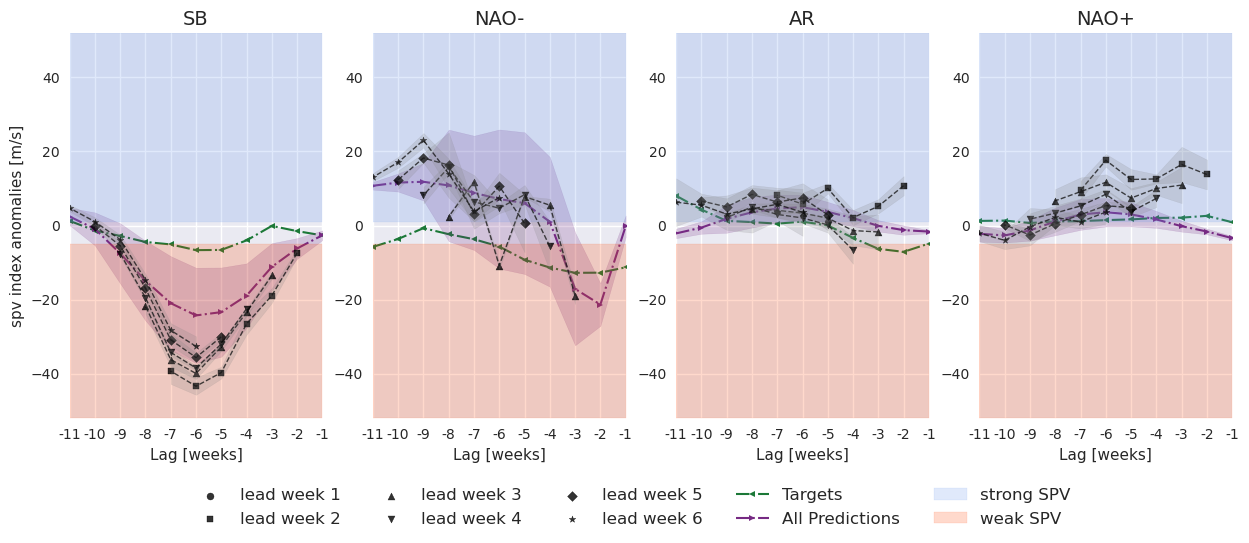

In [ ]:
#add mean targets and all predictions
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf'] 
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_tar_dt[:,:,0].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_tar_dt[:,:,0].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = 52
delta_t = np.unique(np.array(delta_t_pv[regimes[0]]['delta t']))
delta_t = np.arange(1,delta_t[-1]+1)
colors = sns.color_palette("colorblind", n_colors=6)
alphas = np.linspace(0.5,1, 6)
marker_list = ['o','s','^','v','D','*']

for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_reg_mean[i]
    plot_uncert_pv = pv_anom_reg_std[i]
    for t in range(plot_data_pv.shape[0]):
        dt = np.flip(np.arange(len(plot_data_pv[t,:]))+t+1)

        ax.scatter(np.flip(dt), np.flip(plot_data_pv[t,:]), color='black', marker = marker_list[t], s = 25, alpha = 0.8,
                    zorder=2, label = f'lead week {t+1}')

        ax.plot(np.flip(dt), np.flip(plot_data_pv[t,:]), color='black', alpha = 0.8,#alphas[t],
                linestyle='dashed', linewidth=1, zorder=2, )#label = f'lead week {t+1}')
        ax.fill_between(np.flip(dt), np.flip(plot_data_pv[t,:]) - np.flip(plot_uncert_pv[t,:]), 
                np.flip(plot_data_pv[t,:]) + np.flip(plot_uncert_pv[t,:]), color='grey', alpha=0.2, zorder=2)


    ax.plot(np.flip(delta_t),np.flip(pv_anom_tar_dt_mean[i,:]), color=cm_list[1], linewidth=1.5, marker = '<', linestyle = '-.',
            markersize = 5, zorder=1, label = 'Targets') #label = 'ERA 5'
    ax.plot(np.flip(delta_t),np.flip(pv_anom_all_dt_mean[i,:]), color=cm_list[2], linewidth=1.5, marker = '>', linestyle = '-.',
            markersize = 5, zorder=1, label = 'All Predictions') #label = 'All'
    ax.fill_between(np.flip(delta_t), np.flip(pv_anom_all_dt_mean[i,:]) - np.flip(pv_all_dt_anom_stds[i,:]),
                    np.flip(pv_anom_all_dt_mean[i,:]) + np.flip(pv_all_dt_anom_stds[i,:]), color=cm_list[2],alpha=0.2, zorder=1)
    
    ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='cornflowerblue', alpha=0.2, label = 'strong SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='orangered', alpha=0.2, label = 'weak SPV', zorder=1)
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(delta_t)[0], np.flip(delta_t)[-1])
    ax.set_xticks(np.flip(delta_t))
    ax.set_xticklabels(-np.flip(delta_t))
    ax.set_title(f'{keys}', fontsize=14)

    ax.set_xlabel(f'Lag [weeks]')
   

axes[0].set_ylabel(f'spv index anomalies [m/s]')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=5, fontsize =12)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_percentile_spvIndex_shifted_dt.png", dpi=600, bbox_inches='tight')              

In [51]:
np.savez(f'{results_directory}{arch_type}spv_teleconnections.npz', pv_anom_reg_mean = pv_anom_reg_mean, vmax = vmax, strong_perc = strong_perc, med_perc = med_perc, marker_list = marker_list, alphas = alphas,
         delta_t = delta_t, regimes = regimes, pv_anom_tar_dt = pv_anom_tar_dt, pv_anom_tar_dt_mean = pv_anom_tar_dt_mean, pv_anom_all_dt_mean = pv_anom_all_dt_mean, pv_anom_reg_std = pv_anom_reg_std, pv_all_dt_anom_stds = pv_all_dt_anom_stds)